# Simulate auxTel with batoid, compare WEP to CWFS

In [1]:
!pip install galsim
!pip install danish
!pip install batoid

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim

We want to simulate specific Zernike perturbations. We use phase screen. 

First, execute step-by-step elements of the simulation to inspect the intermediate variables:

In [2]:
auxtel = batoid.Optic.fromYaml("AuxTel.yaml")

bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')

seed = 0
rng = np.random.default_rng(seed)

# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}



seed = 0
rng = np.random.default_rng(seed)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# since the wavelength is 622 nm, 
# +/- 200 nm corresponds to +/- 0.3 waves of perturbation
#z_in = rng.uniform(-200e-9, 200e-9, size=12)
z_in = np.zeros(12)
#z_in[0] = 200e-9
phase = batoid.Zernike(
    np.array(z_in),
    R_outer=0.6,
    R_inner=0.2115
)

In [4]:
z_in

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
perturbed = batoid.CompoundOptic(
        (
            batoid.optic.OPDScreen(
                batoid.Plane(),
                phase,
                name='PhaseScreen',
                obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                coordSys=auxtel.stopSurface.coordSys
            ),
            *auxtel.items
        ),
        name='PerturbedAuxTel',
        backDist=auxtel.backDist,
        pupilSize=auxtel.pupilSize,
        inMedium=auxtel.inMedium,
        stopSurface=auxtel.stopSurface,
        sphereRadius=auxtel.sphereRadius,
        pupilObscuration=auxtel.pupilObscuration
    )

In [6]:
intra = perturbed.withGloballyShiftedOptic("M2", [0, 0, -0.0008])
extra = perturbed.withGloballyShiftedOptic("M2", [0, 0, +0.0008])


In [10]:
# start the simulator 
intra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    intra,
    bandpass,
    shape=(2000, 2000),
    rng=rng
)

extra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    extra,
    bandpass,
    shape=(2000, 2000),
    rng=rng
)

In [11]:
wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
# the fractional inner radius is 
# eps = inner_radius / outer_radius = 0.2538 / 0.6 =  0.423 [m]


# choose a position for the star
# these angles specify the angle from the optical axis to the star
thx = np.deg2rad(0)
thy = np.deg2rad(0)


zs = batoid.zernike(perturbed, thx, thy, wavelength, eps=0.3525)#423)
zs*=wavelength  #  waves -> nm 
    

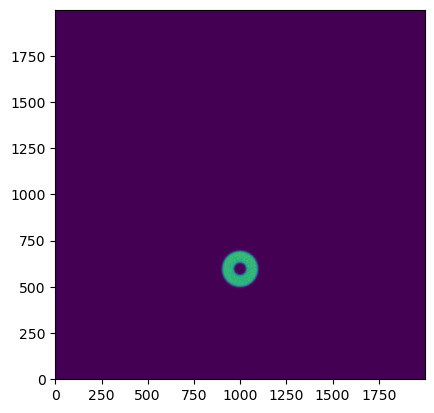

In [12]:
# create a spectrum for the star -- this is needed for chromatic refraction
# we will randomly select a plausible star temperature, 
# and calculate the corresponding blackbody spectrum
star_temp = rng.uniform(4_000, 10_000) # Kelvin
sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

# randomly choose a flux (must be an integer)
flux = rng.integers(1_000_000, 2_000_000)


intra_simulator.add_star(thx, thy, sed, flux, rng)
extra_simulator.add_star(thx, thy, sed, flux, rng)

# seed = 0
plt.imshow(intra_simulator.image.array, origin='lower')



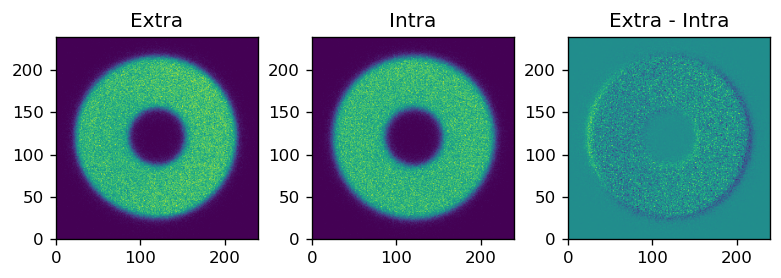

In [20]:
#xcen,ycen = 1595,2000
xcen,ycen=595,1000
dx,dy = 120,120
fig, axes = plt.subplots(1, 3, dpi=120, constrained_layout=True)

extra_stamp = extra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
intra_stamp = intra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
axes[0].imshow(extra_stamp, origin="lower")
axes[0].set_title("Extra",)# color="b")

axes[1].imshow(intra_stamp, origin="lower")
axes[1].set_title("Intra", )#color="b")

axes[2].imshow(extra_stamp-intra_stamp, origin="lower")
axes[2].set_title("Extra - Intra",)# color="w")

#for ax in axes:
#    ax.set(xticks=[], yticks=[])

plt.show()


Wrap that simulation as a function:

In [21]:
def simulate_auxtel_zernikes(seed = 0, z_in = [0,0,0,0,200e-9,0,0,0,0,0,0,0],
                            fname = ""):

    auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
    bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')
    rng = np.random.default_rng(seed)

    # parameters associated with the observing conditions
    obs_params = {
        # zenith=0 means straight up, while zenith=90 is the horizon
        # greater zenith angle means more atmospheric turbulence
        "zenith": 30 * galsim.degrees,

        # raw_seeing sets how much atmospheric turbulence there is at zenith=0
        # wfsim uses this to calculate how much turbulence there is at 
        # the zenith angle given above
        "raw_seeing": 0.7 * galsim.arcsec,

        # these next three parameters set attributes of the atmosphere, which
        # help determine how much turbulence there is
        "temperature": 293, # Kelvin
        "pressure": 69, # kPa
        "H2O_pressure": 1, # kPa

        # wavelength of the observed light. this is important because light of 
        # longer/shorter wavelength refracts less/more in the atmosphere
        "wavelength": bandpass.effective_wavelength, # nanometers

        # the AuxTel exposure time
        "exptime": 30, # seconds
    }

    # parameters associated with computational aspects of simulating the atmosphere
    atm_params = {
        "screen_size": 819.2,
        "screen_scale": 0.1,
        "nproc": 6,
    }

    # since the wavelength is 622 nm, 
    # +/- 200 nm corresponds to +/- 0.3 waves of perturbation
    #z_in = rng.uniform(-200e-9, 200e-9, size=12)
    
    #z_in = np.zeros(12)
    #z_in[5] = 200e-9
    phase = batoid.Zernike(
        np.array(z_in),
        R_outer=0.6,
        R_inner=0.2115
        
    )
    perturbed = batoid.CompoundOptic(
            (
            batoid.optic.OPDScreen(
                batoid.Plane(),
                phase,
                name='PhaseScreen',
                obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                coordSys=auxtel.stopSurface.coordSys
            ),
            *auxtel.items
        ),
        name='PerturbedAuxTel',
        backDist=auxtel.backDist,
        pupilSize=auxtel.pupilSize,
        inMedium=auxtel.inMedium,
        stopSurface=auxtel.stopSurface,
        sphereRadius=auxtel.sphereRadius,
        pupilObscuration=auxtel.pupilObscuration
    )


    intra = perturbed.withGloballyShiftedOptic("M2", [0, 0, -0.0008])
    extra = perturbed.withGloballyShiftedOptic("M2", [0, 0, +0.0008])


    # start the simulator 
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
    # the fractional inner radius is 
    # eps = inner_radius / outer_radius = 0.2538 / 0.6 =  0.423 [m]


    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(0)
    thy = np.deg2rad(0)


    zs = batoid.zernike(perturbed, thx, thy, wavelength, eps=0.3525)
    zs*=wavelength  #  waves -> m 
    
    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = 1800000#rng.integers(1_000_000, 2_000_000)

    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)

    print(f'saved {fname}')
    fpath = os.path.join('DM-37396',fname)
    np.savez(fpath,
        intra=intra_simulator.image.array,
        extra=extra_simulator.image.array, 
        zktruth=zs)
    return intra_simulator.image.array, extra_simulator.image.array, zs


Fit with ts_wep:  (`v4.0.0`) lsst_distrib `w2023_02` 

In [35]:
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

import numpy as np

def fit_ts_wep(intra_stamp, extra_stamp, fieldXYIntra=np.zeros(2), 
               fieldXYExtra=np.zeros(2), sizeInPix = 240,
              opticalModel = 'onAxis'):
    #fieldXY = np.zeros(2)

    instName = 'auxTel'
    
     # here we make bigger stamps than the usual 200  # donut stamp size 
    configDir = getConfigDir()
    algoDir = os.path.join(configDir, "cwfs", "algo")
    tol=1e-3

    # this is part of the init
    inst = Instrument()
    algo = Algorithm(algoDir)

    # inside estimateZernikes()
    camType = getCamType(instName)

    # inside wfEsti.config
    inst.configFromFile(sizeInPix, camType)

    # choose the solver for the algorithm
    solver = 'exp' # by default
    debugLevel = 1 # 1 to 3
    algo.config(solver, inst, debugLevel=debugLevel)

    centroidFindType = CentroidFindType.RandomWalk
    imgIntra = CompensableImage(centroidFindType=centroidFindType)
    imgExtra = CompensableImage(centroidFindType=centroidFindType)

    #fieldXYIntra = fieldXY
    #fieldXYExtra = fieldXYIntra

    # now inside  `wfEsti.setImg` method,
    # which inherits from `CompensableImage`
    imgExtra.setImg(fieldXYExtra,
                    DefocalType.Extra,
                    image = extra_stamp)
  
    imgIntra.setImg(fieldXYIntra,
                    DefocalType.Intra,
                    image = intra_stamp)
    
    algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

    zer4UpInNm = algo.getZer4UpInNm()
    
    return zer4UpInNm



In [23]:
wepZk = {}
for model in ['onAxis', 'paraxial']:
    wepZk[model] = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix = 240.,
                             opticalModel=model)

Fit with CWFS:

In [44]:
# run the CWFS fit ...
from lsst import cwfs
from lsst.cwfs.algorithm import Algorithm as AlgorithmCwfs
from lsst.cwfs.image import Image
from lsst.cwfs.instrument import Instrument as InstrumentCwfs
from pathlib import Path


def fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXYIntra = [0.0, 0.0], fieldXYExtra=[0.0, 0.0],
            opticalModel="paraxial", obscuration=0.3525, _dz =  0.8):
    '''
     There is  "defocal offset" with a value of 32.8 mm  from 
     https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
     
     The value of _dz=0.8  is used in latiss_base_align.py;
     if I set _dz = 0.8, then   0.8*0.041  = 32.8 * 1e-3 , i.e. same as in ts_wep config ....
     
     Originally the cwfs param has:

    #Auxiliary Telescope parameters:
    Obscuration                             0.3525
    Focal_length (m)                        21.6
    Aperture_diameter (m)                   1.2
    Offset (m)                              0.0205
    Pixel_size (m)                          1.44e-5

    (from https://github.com/lsst-ts/cwfs/blob/master/data/AuxTel/AuxTel.param )

    '''
    # this value is in the latiss_base_align.py
    # if I set _dz = 0.8, then   0.8*0.041  = 32.8 * 1e-3 , i.e. same as in ts_wep config ....
    binning = 1  
    #side = 110  #  https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/tests/auxtel/test_latiss_cwfs_align.py#L525
    # from https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L169

    #0.0205

    # Create configuration file with the proper parameters
    cwfs_config_template = f"""#Auxiliary Telescope parameters:
    Obscuration 				{obscuration}
    Focal_length (m)			21.6
    Aperture_diameter (m)   		1.2
    Offset (m)				{_dz * 0.041}
    Pixel_size (m)			{10e-6 *binning}
    """
    config_index = "auxtel_latiss"
    path = Path(cwfs.__file__).resolve().parents[3].joinpath("data", config_index)
    #print(path)
    if not path.exists():
        os.makedirs(path)
    dest = path.joinpath(f"{config_index}.param")
    with open(dest, "w") as fp:
        # Write the file and set the offset and pixel size parameters
        fp.write(cwfs_config_template)

    inst = InstrumentCwfs(config_index, int(side * 2 / binning))
    algo = AlgorithmCwfs("exp", inst, 1)

    # initialize intra and extra stamps 
    I1 = Image(intra_stamp, fieldXYIntra, Image.INTRA)
    I2 = Image(extra_stamp, fieldXYExtra, Image.EXTRA)


    algo.reset(I1,I2)
    algo.runIt(inst, I1, I2, opticalModel)
    zer4UpNm = algo.zer4UpNm

    # return the fit result
    return zer4UpNm

In [25]:
cwfsZk = {}
for model in ['onAxis', 'paraxial']:
    cwfsZk[model] =  fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXY = [0.0, 0.0],
                      opticalModel=model)

Compare: 

In [28]:
cwfsZk

{'onAxis': array([-4.41443336,  3.560108  , 10.34487922,  1.88899933,  8.74296773,
        -5.76127771,  9.07940456,  1.2041369 ,  1.11445765,  0.01259721,
         0.96540851, -0.38622139,  0.125849  ,  1.22872546, -0.63069983,
         0.03950574,  1.37207007,  0.63112001, -0.23958622]),
 'paraxial': array([-5.29479037e+00,  4.17270825e+00,  1.12549207e+01,  5.20971895e+00,
         6.82910758e+00, -5.38898701e+00,  8.63998744e+00,  1.14048417e+00,
         1.06277375e+00,  5.56235352e-03,  9.98987122e-01, -5.18114378e-01,
         7.57471537e-01,  1.34073673e-01, -6.24061316e-01,  3.59971574e-02,
         1.48611348e+00,  4.92532701e-01, -2.34396544e-01])}

Text(0.5, 1.0, 'onAxis, null input')

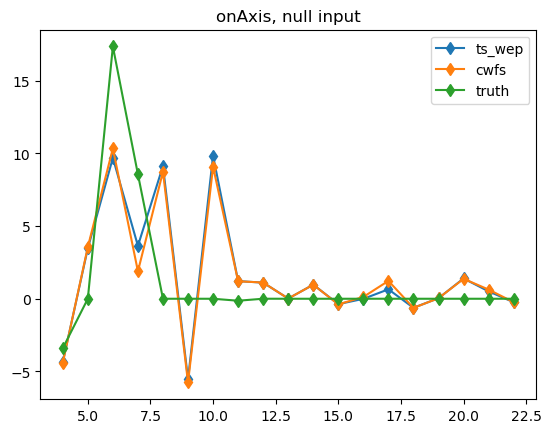

In [30]:
model='onAxis'
outputZernikesRawwepZk[model], '-d', label='ts_wep')
plt.plot(np.arange(4,23), cwfsZk[model], '-d', label='cwfs')
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')
plt.legend()
plt.title(f'{model}, null input')


Text(0.5, 1.0, 'paraxial, null input')

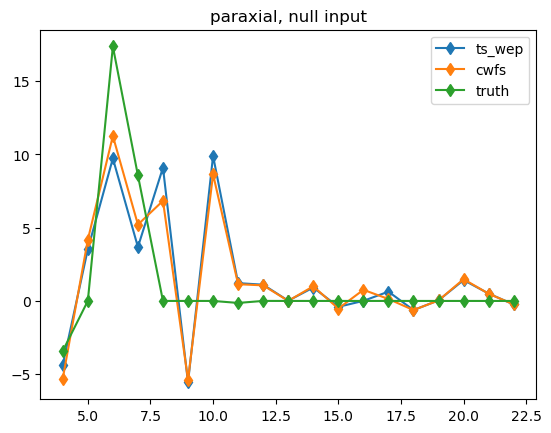

In [31]:
model='paraxial'
plt.plot(np.arange(4,23), wepZk[model], '-d', label='ts_wep')
plt.plot(np.arange(4,23), cwfsZk[model], '-d', label='cwfs')
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')
plt.legend()
plt.title(f'{model}, null input')

Plot the difference from "truth":

Text(0.5, 1.0, 'onAxis')

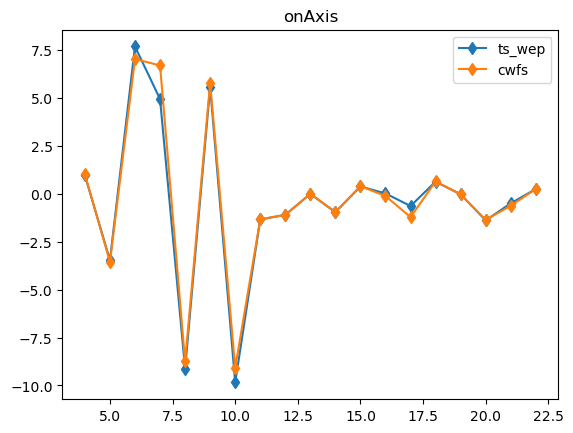

In [32]:
model='onAxis'
plt.plot(np.arange(4,23), zs[4:]*1e9-wepZk[model], '-d', label='ts_wep')
plt.plot(np.arange(4,23), zs[4:]*1e9-cwfsZk[model], '-d', label='cwfs')
#plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')
plt.legend()
plt.title(model)

Text(0.5, 1.0, 'paraxial')

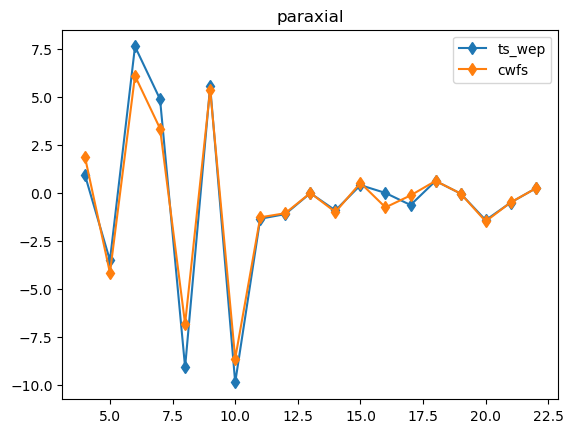

In [33]:
model='paraxial'
plt.plot(np.arange(4,23), zs[4:]*1e9-wepZk[model], '-d', label='ts_wep')
plt.plot(np.arange(4,23), zs[4:]*1e9-cwfsZk[model], '-d', label='cwfs')
#plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')
plt.legend()
plt.title(model)

plot just `ts_wep` two models: 

Text(0.5, 1.0, 'ts_wep truth-fit')

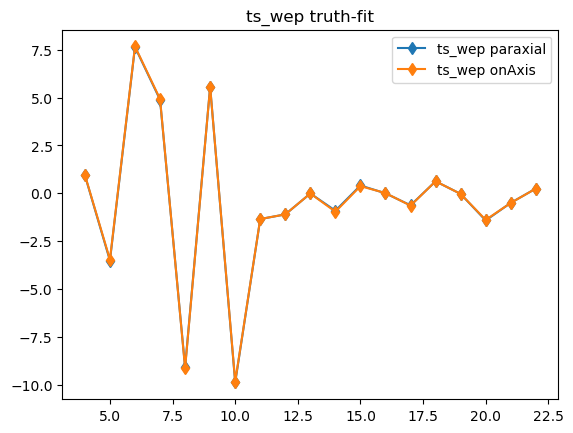

In [34]:
for model in ['paraxial','onAxis']:
    plt.plot(np.arange(4,23), zs[4:]*1e9-wepZk[model], '-d', label=f'ts_wep {model}')

plt.legend()
plt.title('ts_wep truth-fit')

Text(0.5, 1.0, 'cwfs truth-fit')

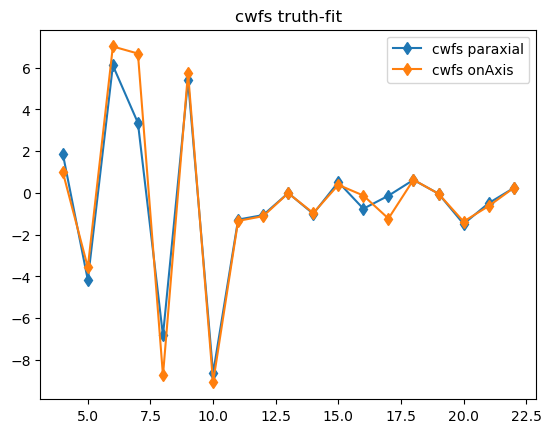

In [35]:
for model in ['paraxial','onAxis']:
    plt.plot(np.arange(4,23), zs[4:]*1e9-cwfsZk[model], '-d', label=f'cwfs {model}')

plt.legend()
plt.title('cwfs truth-fit')

All these are very similar. But run simulations for a variety of Zks, with various magnitudes too. 

Wrap the above as a function, so that we can edit the seed and the amount of perturbation:

In [ ]:
intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
                            fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz")

In [5]:
import time

That's taking waay too long ... Is there something wrong?  Put it in a script and submit to slurm...

Call it `simBatoid.py`,

and make `runSlurm.sl` 

--> this is still not working... 

--> Why is it taking so long ? 

In [37]:
# for auxtel_a_seed0... I was using eps= 0.423 for zs=batoid .. and in CWFS config
# for auxtel_b_seed. .. I changed eps=0.3525 when reading zs from batoid.zernike, 
# and add R_inner=0.2115 to batoid.Zernike  call
# changed in CWFS config the obscuration from 0.423 to 0.3525  (assuming that )
import time 

seed = 0
N = 12  # that's Z4:Z11 (presumably )
for i in range(N):
    z_in = np.zeros(N)
    z_in[i] = 200e-9
    print(i, z_in)
    t1 = time.time()
    intra_image, extra_image, zk_true = simulate_auxtel_zernikes(seed = seed, z_in = z_in,
                            fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz")
    t2 = time.time()

    dt = t2-t1 #[seconds]
    print(f'took {dt} seconds\n')
 

0 [2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z0.npz
took 67.13557767868042 seconds

1 [0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z1.npz
took 94.56714248657227 seconds

2 [0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z2.npz
took 76.15850257873535 seconds

3 [0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z3.npz
took 84.5181131362915 seconds

4 [0.e+00 0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z4.npz
took 91.73158431053162 seconds

5 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-07 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
saved auxtel_b_seed0_image_truth_z5.npz
took 85.48847436904907 seconds

6 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+

Just use `onAxis` given that we have more agreement from the one test.

In [38]:
def cut_stamp(image,xcen=1595,ycen=2000,side=120):
    dx = side
    dy = side
    return image[xcen-dx:xcen+dx, ycen-dy:ycen+dy]


In [41]:
intra_stamp = cut_stamp(intra_image)
extra_stamp = cut_stamp(extra_image)
model = 'onAxis'
wepZk = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix = 240.,
           opticalModel=model)

cwfsZk = fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXY = [0.0, 0.0],
                      opticalModel=model)


/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/cwfs/data/auxtel_latiss


Fit the `zk4-11` simulation above:

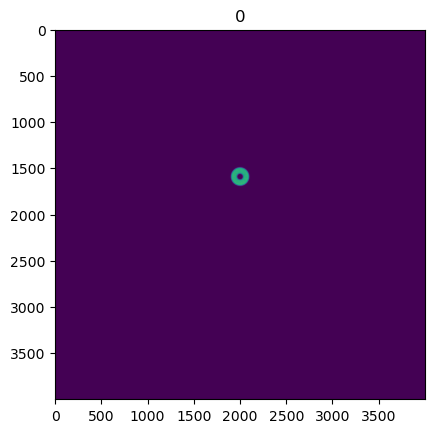

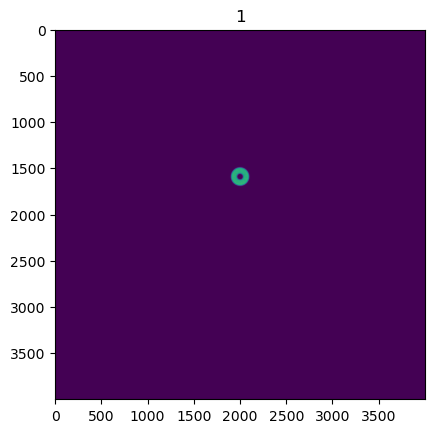

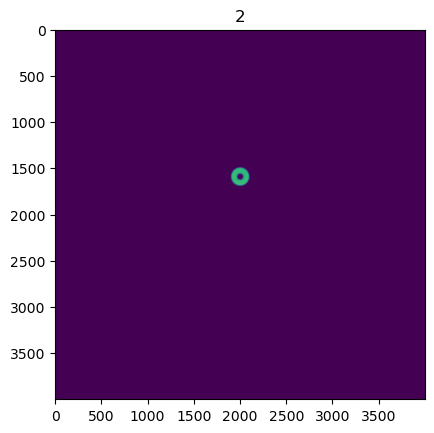

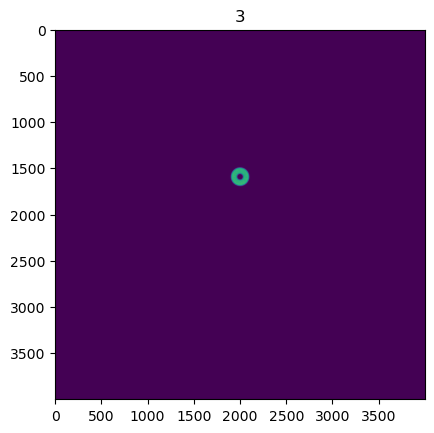

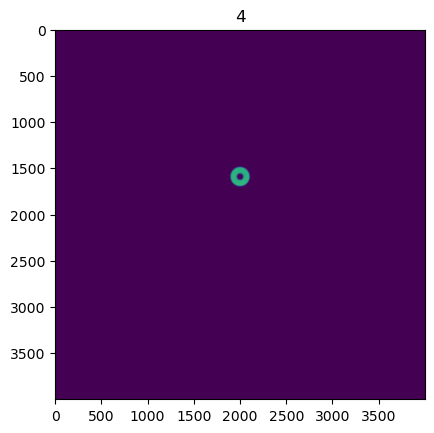

In [49]:
for i in range(5):
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    intra_image = npz['intra']
    plt.figure()
    plt.imshow(intra_image)
    plt.title(i)

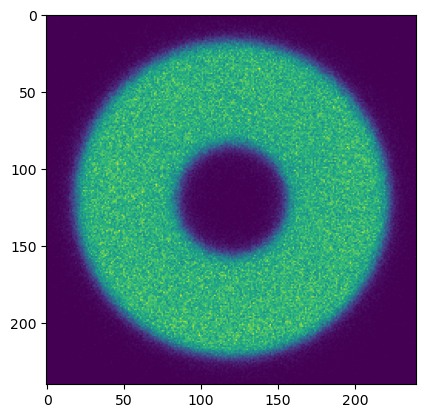

In [50]:
intra_stamp = cut_stamp(intra_image)
plt.imshow(intra_stamp)

In [51]:
res = {'wep':{}, 'cwfs':{}, 'truth':{}, 'img':{}}
seed =0 
model = 'onAxis'
for i in range(12):
    
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37396',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zktruth']
    
    intra_stamp = cut_stamp(intra_image)#, xcen=595, ycen=1000)
    extra_stamp = cut_stamp(extra_image)#, xcen=595, ycen=1000)
    
    wepZk = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix = 240.,
           opticalModel=model)
    res['wep'][i] = wepZk
    
    cwfsZk = fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXY = [0.0, 0.0],
                      opticalModel=model)
    res['cwfs'][i] = cwfsZk
    
    res['truth'][i] = zk
    
    res['img'][i]  = intra_stamp

In [40]:
def compare_zks(cwfsZk,wepZk, zk_true, i, value=200):
    plt.figure()
    plt.plot(np.arange(4,23), wepZk, '-d', label='ts_wep')
    plt.plot(np.arange(4,23), cwfsZk, '-d', label='cwfs')
    plt.plot(np.arange(4,23), zk_true[4:]*1e9,'-d', label='truth')
    plt.xticks(range(4,22)[::2])
    plt.title(f'zk{i}=200[nm]')
    plt.legend()
    plt.xlabel('Zk coefficient')
    plt.ylabel('Zk value [nm]')

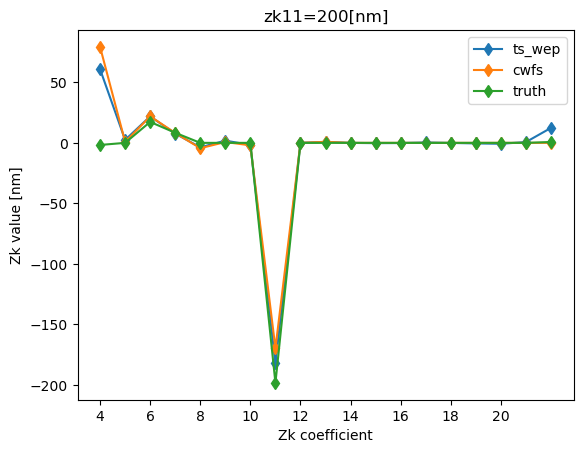

In [53]:
compare_zks(cwfsZk, wepZk, zk_true, i)

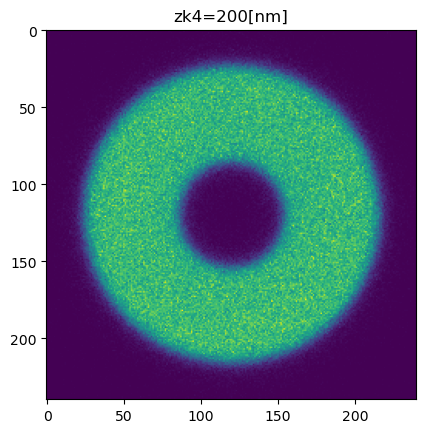

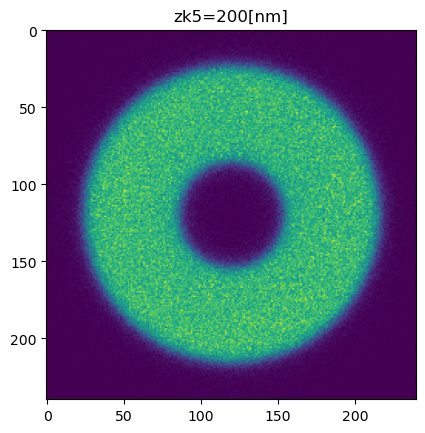

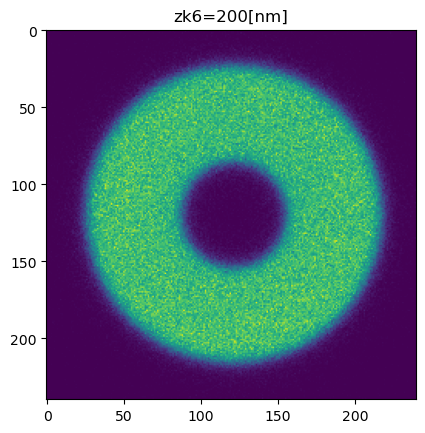

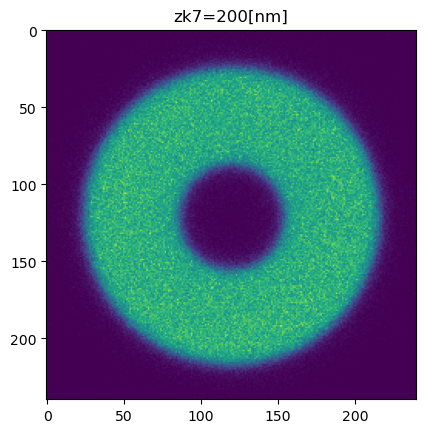

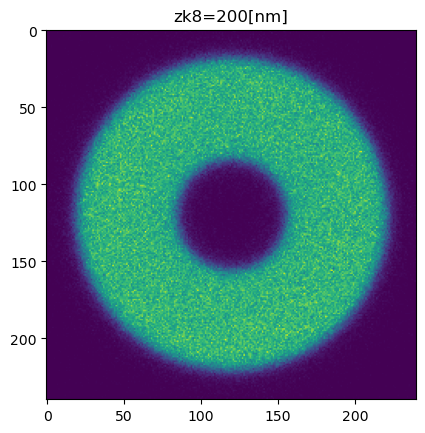

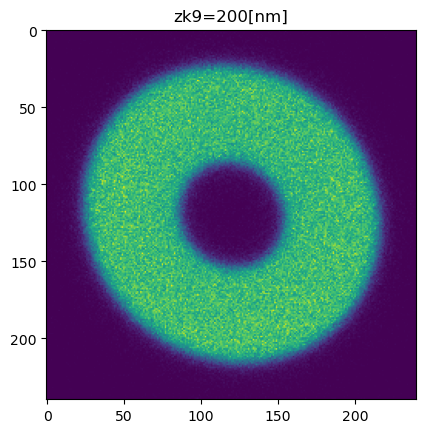

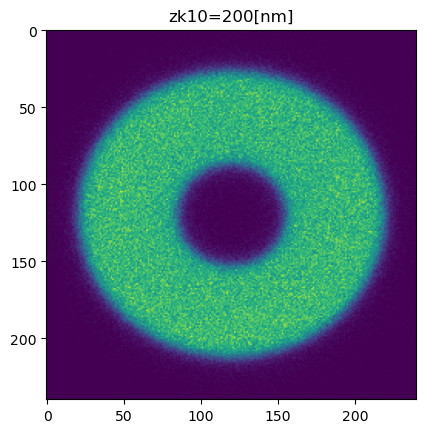

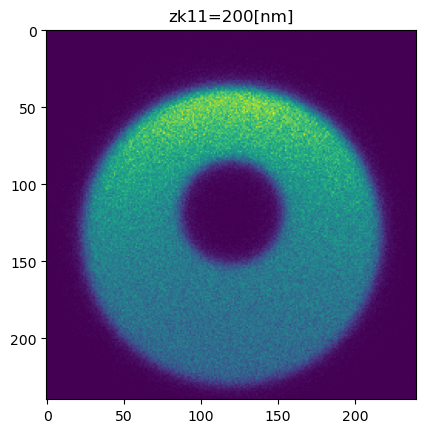

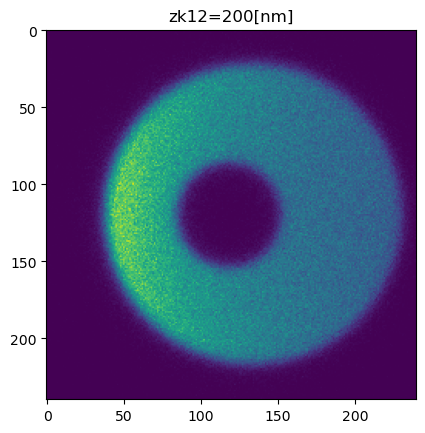

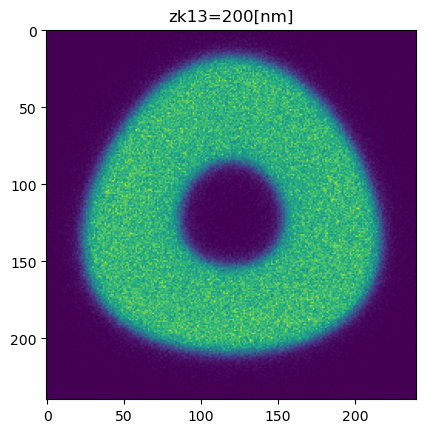

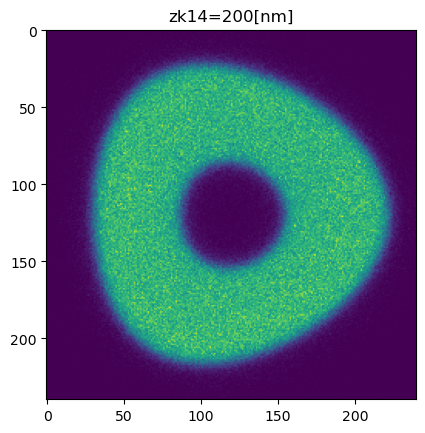

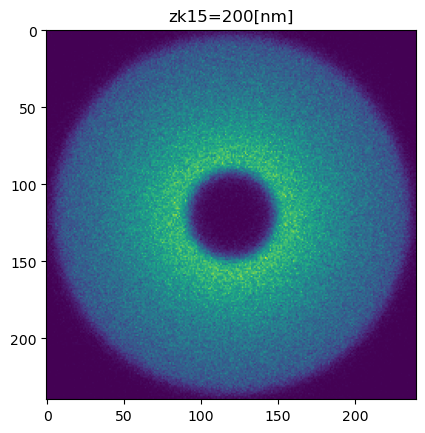

In [54]:
# auxtel_a_....
for i in range(12):
    plt.figure()
    plt.title(f'zk{i+4}=200[nm]')
    plt.imshow(res['img'][i])

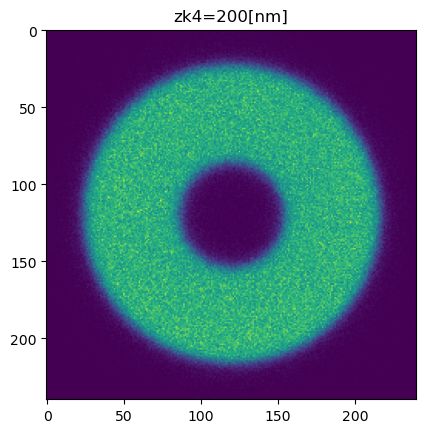

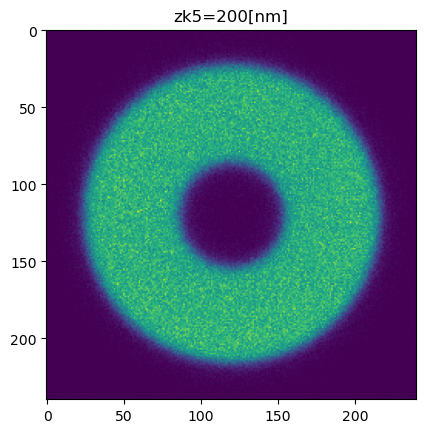

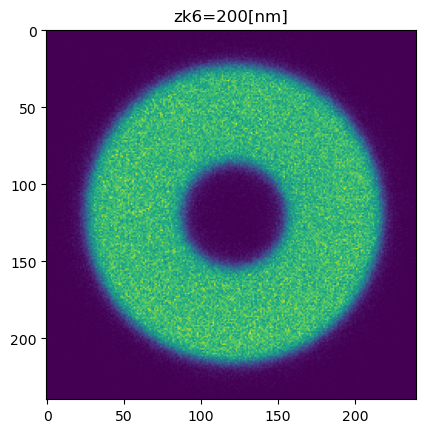

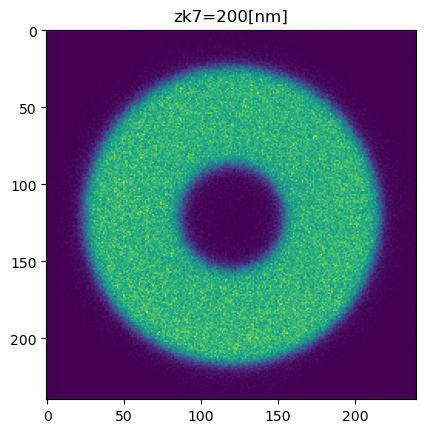

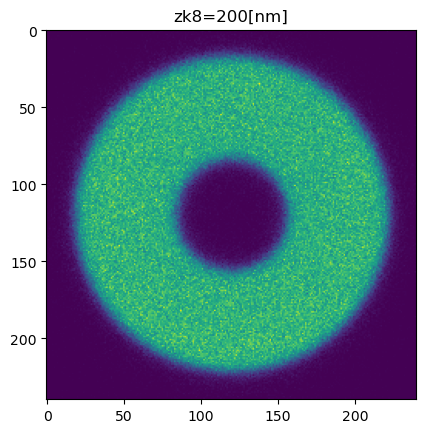

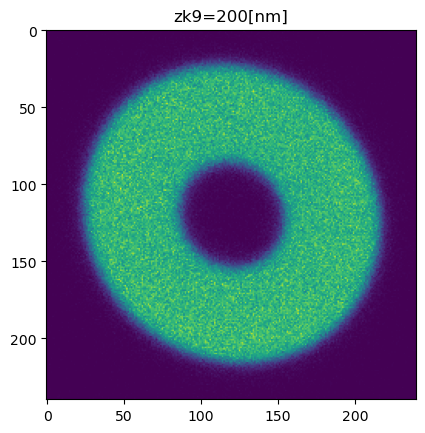

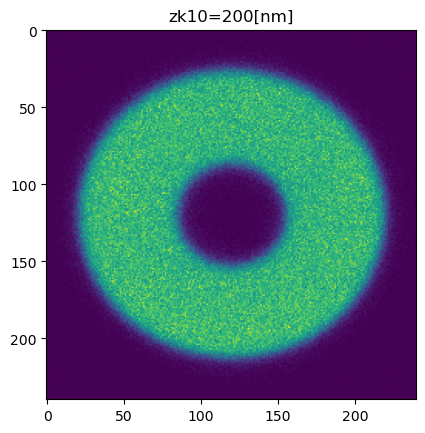

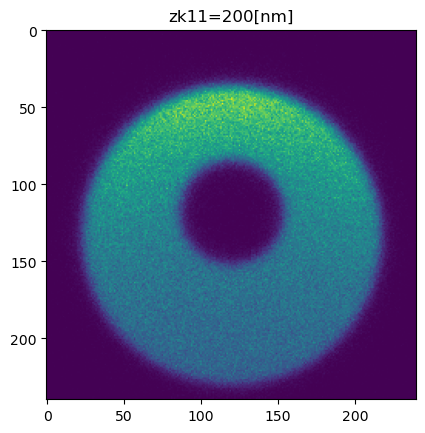

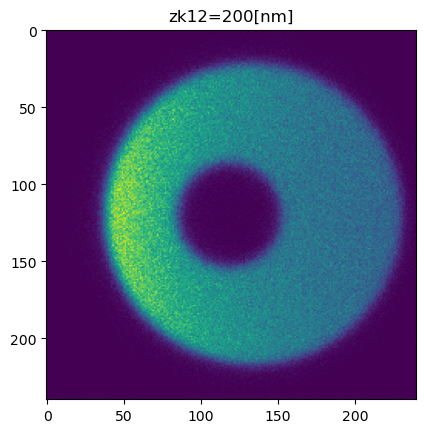

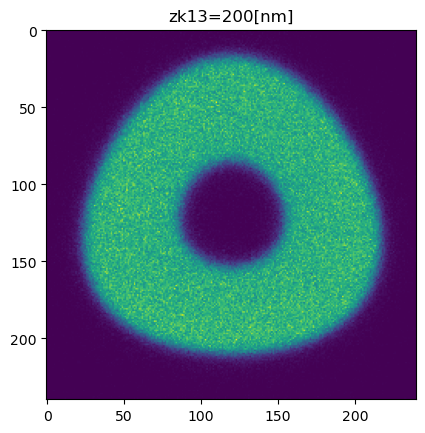

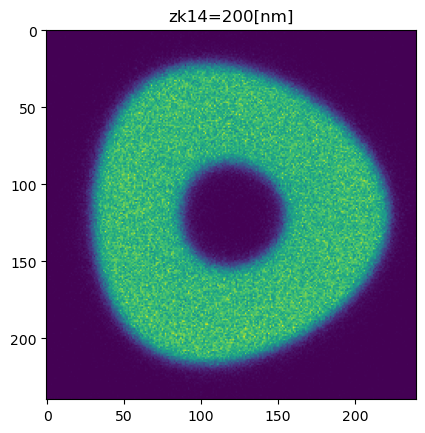

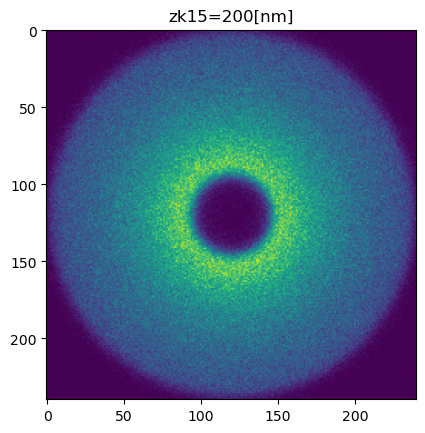

In [54]:
# auxtel_b_....
for i in range(12):
    plt.figure()
    plt.title(f'zk{i+4}=200[nm]')
    plt.imshow(res['img'][i])

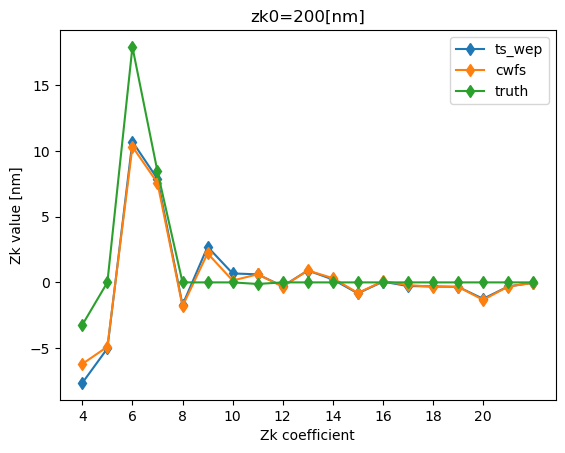

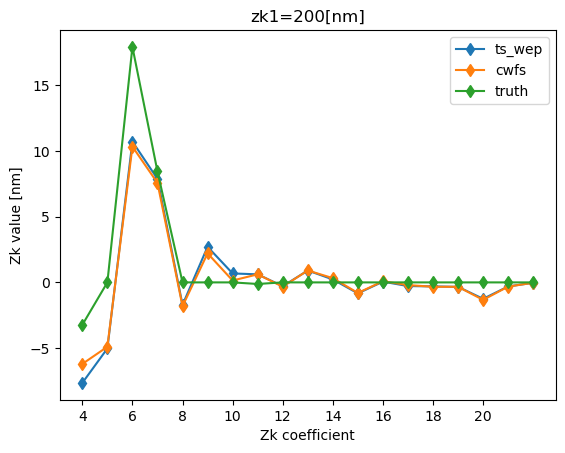

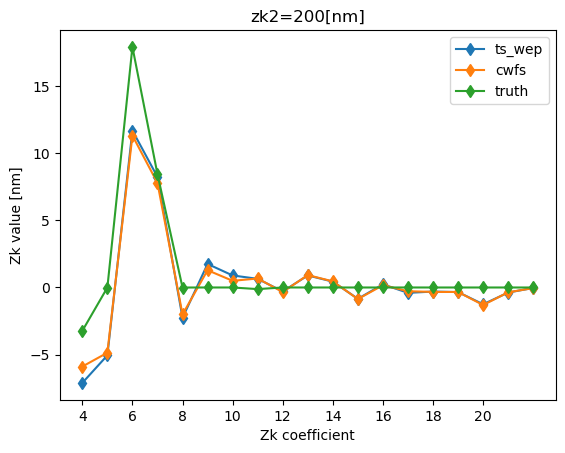

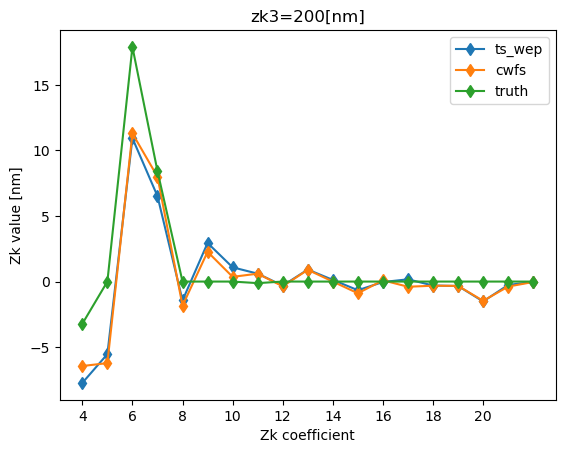

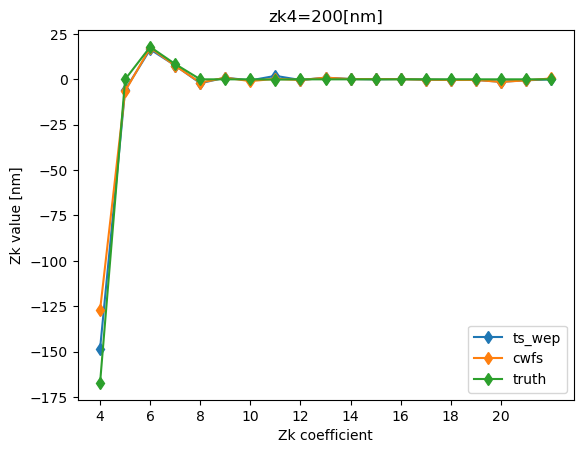

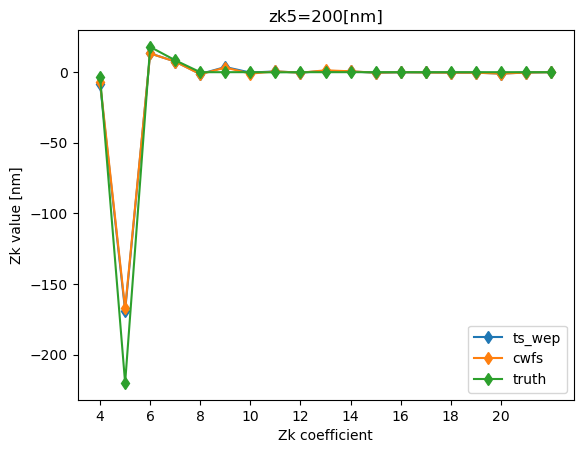

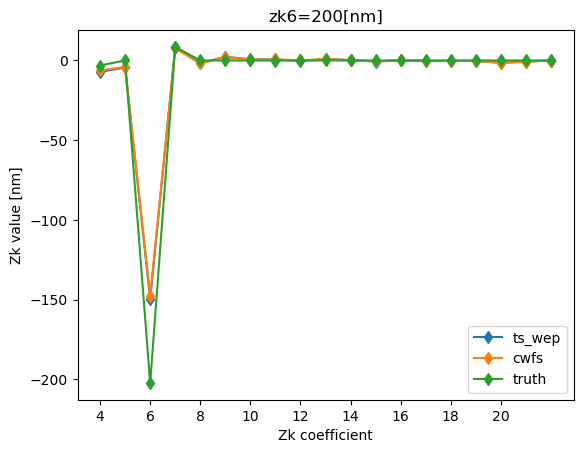

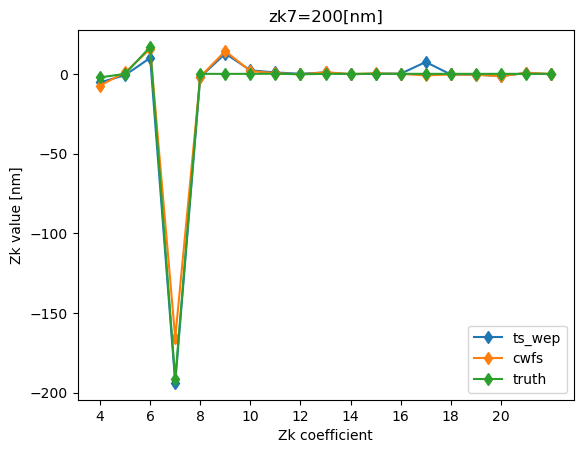

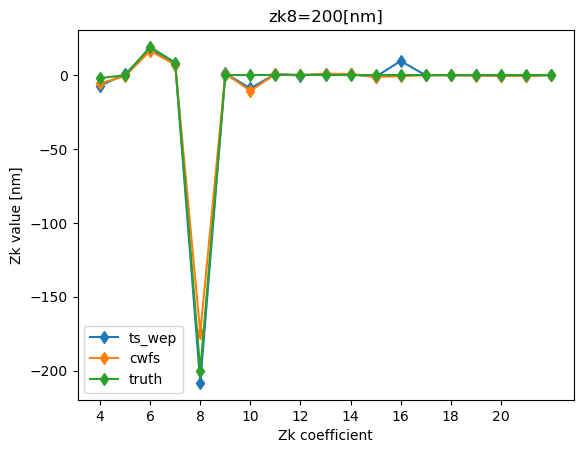

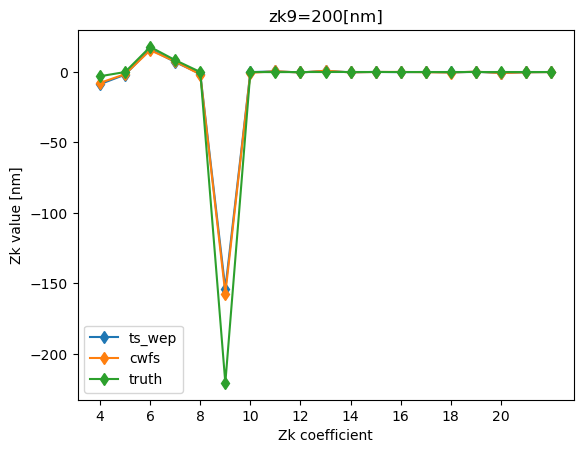

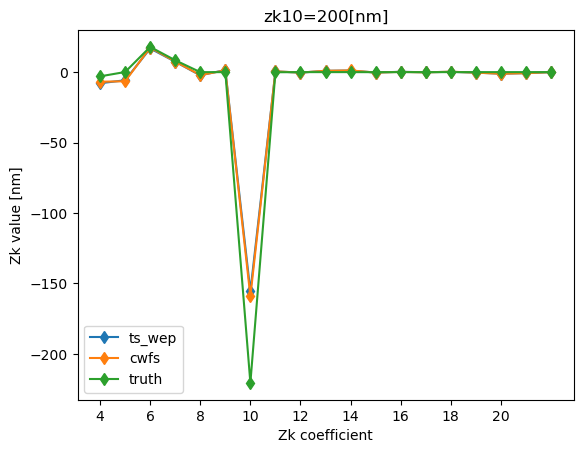

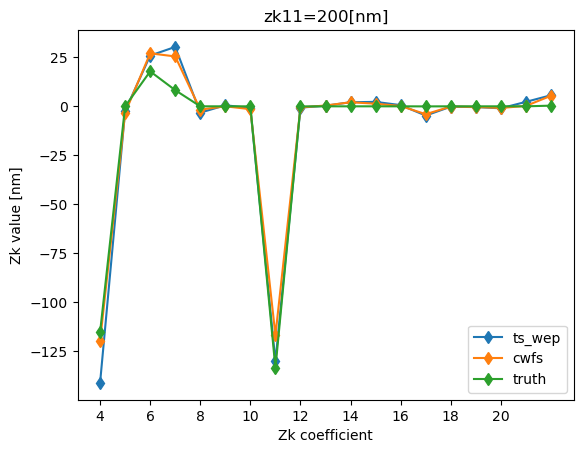

In [68]:
# auxtel_a ....
for i in range(12):
        compare_zks(res['cwfs'][i], res['wep'][i], res['truth'][i], i,value=200)

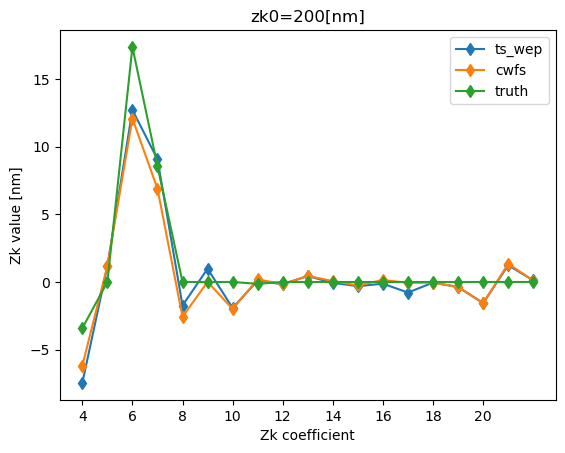

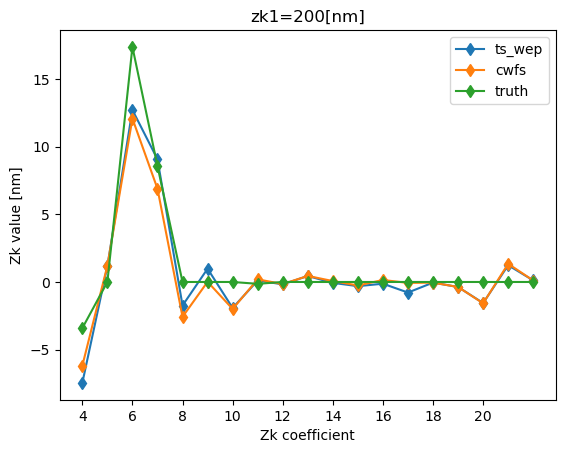

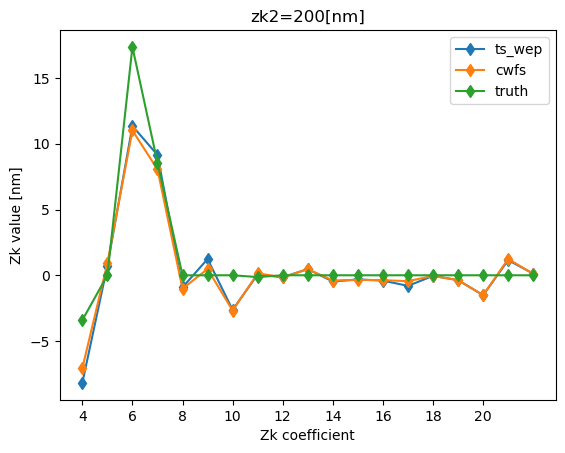

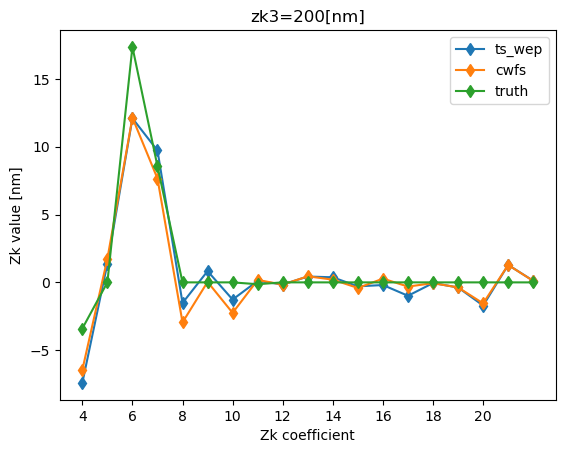

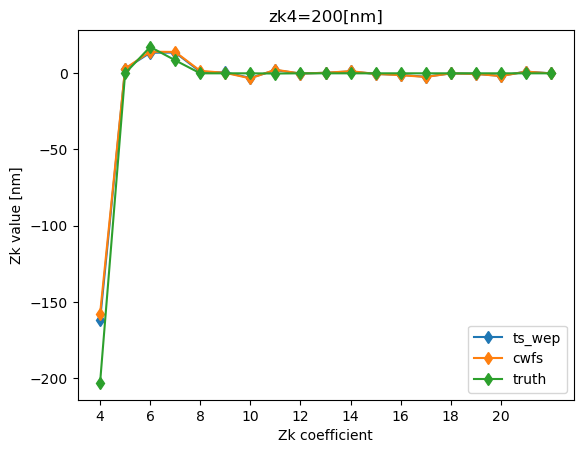

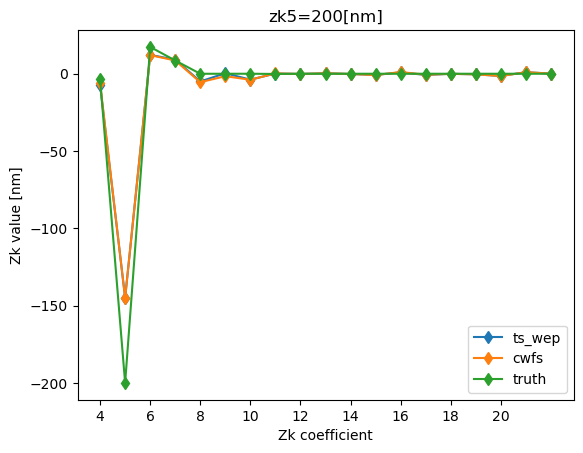

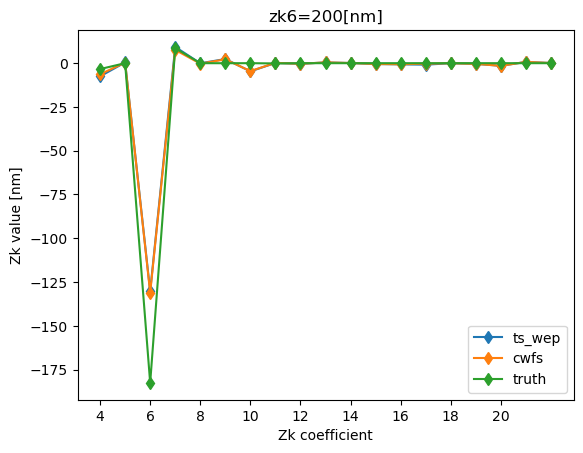

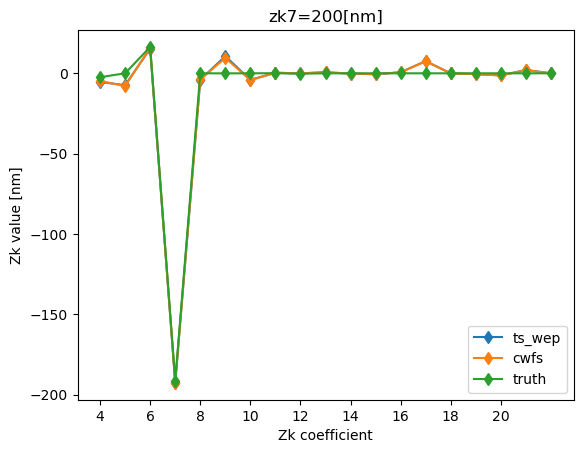

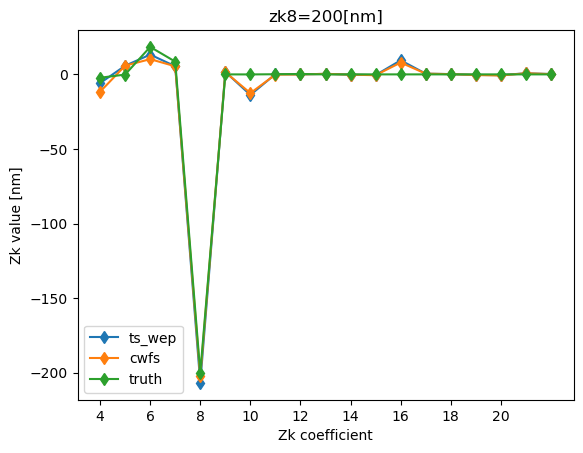

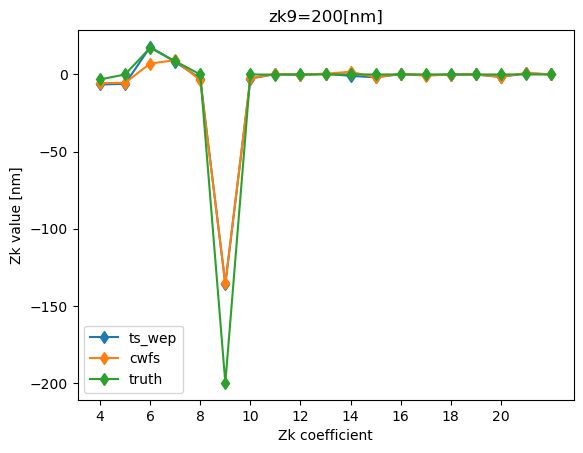

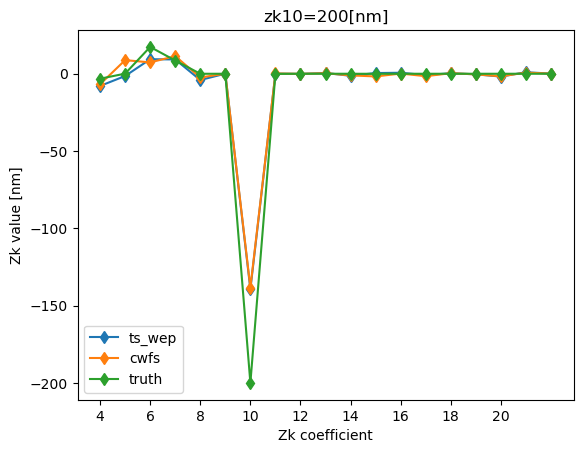

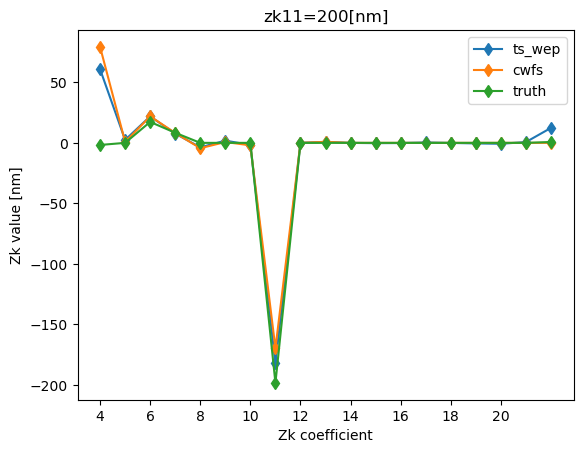

In [55]:
# auxtel_b 
for i in range(12):
        compare_zks(res['cwfs'][i], res['wep'][i], res['truth'][i], i,value=200)
        
        

## Fit the auxTel 20211104 test data with the same settings as above

In [2]:
from lsst.daf import butler as dafButler
instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/sdf/data/rubin/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
# this has the ISR that was run in AOS_DM-37396_auxTel_wep_cwfs.ipynb
collection = 'u/scichris/Latiss/testCwfs'

Text(0.5, 1.0, 'extra')

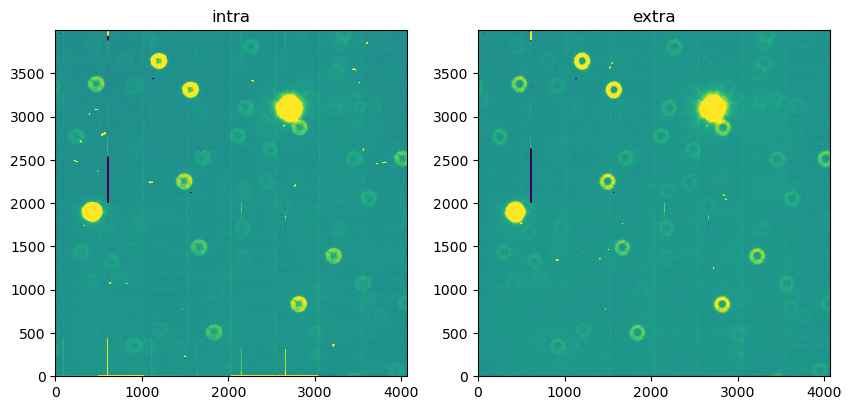

In [4]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
intra_data_id = {'day_obs': 20211104, 'seq_num': 954, 'detector': 0, 'instrument': 'LATISS'}
extra_data_id = {'day_obs': 20211104, 'seq_num': 955, 'detector': 0, 'instrument': 'LATISS'}

intra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=intra_data_id,
              collections=[collection])

extra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=extra_data_id,
              collections=[collection])

fig,ax = plt.subplots(1,2,figsize=(10,5))
data  = intra_exposure.image.array
vmin, vmax = zscale.get_limits(data)
ax[0].imshow(data, origin='lower', vmin=vmin,vmax=vmax)
ax[0].set_title('intra')

data  = extra_exposure.image.array
vmin, vmax = zscale.get_limits(data)
ax[1].imshow(data, origin='lower', vmin=vmin,vmax=vmax)
ax[1].set_title('extra')

## Fit with CWFS / WEP codes using diret access to algorithm, manually cutting donuts 

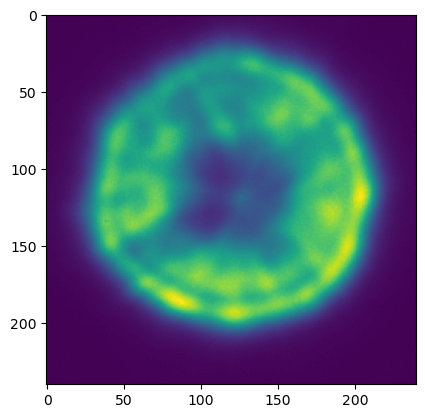

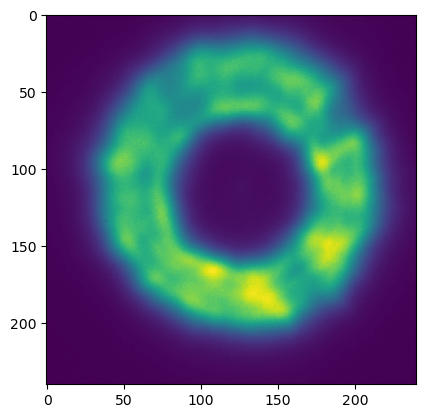

In [59]:
intra_stamp = cut_stamp(intra_exposure.image.array, xcen=3098, ycen=2708)
extra_stamp = cut_stamp(extra_exposure.image.array, xcen=3098, ycen=2708)
plt.figure()
plt.imshow(intra_stamp)
plt.figure()
plt.imshow(extra_stamp)

The expected "truth" is 
[zk3,zk4,zk0] : 
[-60, 30, 50 ]

In [82]:
obscuration = 0.423

cwfsZk = {}
wepZk = {}

for model in ['onAxis', 'paraxial']:
    cwfsZk[model] =  fit_cwfs(intra_stamp, extra_stamp, side=120, fieldXY = [0.0, 0.0],
                  opticalModel=model, obscuration=obscuration)
    
    wepZk[model] = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix = 240.,
       opticalModel=model)

print(f'cwfs obscuration = {obscuration}')
      
for model, name in zip([wepZk, cwfsZk],
                       ['wep','cwfs']):
    indices = np.array([3,4,0])
    print(f'{name},  zk{indices}')
    for optical in ['paraxial', 'onAxis']:
        print('  ', optical, model[optical][indices])
    


cwfs obscuration = 0.423
wep,  zk[3 4 0]
   paraxial [66.5005612  35.41708688 71.7400073 ]
   onAxis [66.4078707  41.71824437 72.44878706]
cwfs,  zk[3 4 0]
   paraxial [59.73379934 30.60085417 50.73205137]
   onAxis [59.09897731 30.75532185 50.87899948]


Setting obscuration to **incorrect** value of `0.423` in `cwfs` gives the desired "truth" results . But `wep` has always `0.3525` as coded in the instrument https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml 

In [80]:
obscuration = .3525
print(f'cwfs obscuration = {obscuration}')
      
for model, name in zip([wepZk, cwfsZk],
                       ['wep','cwfs']):
    indices = np.array([3,4,0])
    print(f'{name},  zk{indices}')
    for optical in ['paraxial', 'onAxis']:
        print('  ', optical, model[optical][indices])
    


cwfs obscuration = 0.3525
wep,  zk[3 4 0]
   paraxial [66.5005612  35.41708688 71.7400073 ]
   onAxis [66.4078707  41.71824437 72.44878706]
cwfs,  zk[3 4 0]
   paraxial [61.30760743 37.332138   90.36697791]
   onAxis [65.46545243 40.89667399 90.28558608]


So actually there's a good agreement! Try to see what could have caused the fitting in `latiss_test` to give such drastic difference... Stamp size? try those huge stamps of 420x420px  (`side` is half the stamp size). 

In [85]:
side = 192 * 1.1
side

211.20000000000002

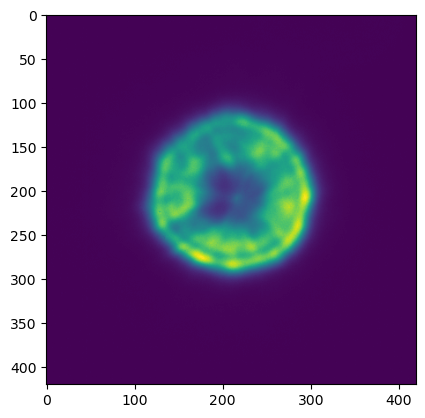

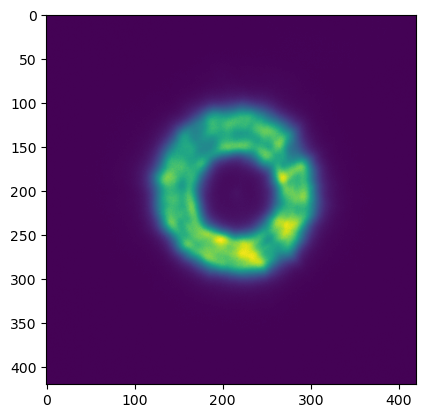

In [86]:
intra_stamp = cut_stamp(intra_exposure.image.array, xcen=3098, ycen=2708, side=210)
extra_stamp = cut_stamp(extra_exposure.image.array, xcen=3098, ycen=2708, side=210)
plt.figure()
plt.imshow(intra_stamp)
plt.figure()
plt.imshow(extra_stamp)

In [89]:
print(np.shape(intra_stamp))
print(np.shape(extra_stamp))

(420, 420)
(420, 420)


In [93]:
side = 210

In [92]:
obscuration = .3525
print(f'cwfs obscuration = {obscuration}')

cwfsZk = {}
wepZk = {}

for model in ['onAxis', 'paraxial']:
    cwfsZk[model] =  fit_cwfs(intra_stamp, extra_stamp, side=210, fieldXY = [0.0, 0.0],
                  opticalModel=model, obscuration=obscuration)
    
    wepZk[model] = fit_ts_wep(intra_stamp, extra_stamp, fieldXY=np.zeros(2), sizeInPix =420,
       opticalModel=model)

    
for model, name in zip([wepZk, cwfsZk],
                       ['wep','cwfs']):
    indices = np.array([3,4,0])
    print(f'{name},  zk{indices}')
    for optical in ['paraxial', 'onAxis']:
        print('  ', optical, model[optical][indices])
    


cwfs obscuration = 0.3525
wep,  zk[3 4 0]
   paraxial [66.5005612  35.41708688 71.7400073 ]
   onAxis [66.4078707  41.71824437 72.44878706]
cwfs,  zk[3 4 0]
   paraxial [61.2194822  40.71669334 90.19797476]
   onAxis [65.46545243 40.89667399 90.28558608]


cwfs  obscuration 0.3525 side 120 px 

  * paraxial [61.30760743 37.332138   90.36697791]
  * onAxis [65.46545243 40.89667399 90.28558608]

cwfs obscuration 0.3525 side 210 px 

  *  paraxial [61.2194822  40.71669334 90.19797476]
  * onAxis [65.46545243 40.89667399 90.28558608]

only few nm, especially in `paraxial` model.  In `onAxis ` the results are bitwise identical ... 

So still I can't recover the weird ts_wep results I was getting... 

Nxt: 
    
    * Find out what is the difference between my setup and what Tiago is using, since I am actually getting an agreement! Although I think that the "truth" he was using was off, because he was using wrong obscuration to get the result ... I think that "truth" should be  the `cwfs/wep` result with `obscuration` of `0.3525`, and `opticalModel` [65,]

## Fit with WEP using EstimateZernikesLatissTask, cutout donuts based on centroid 

Ok, so in `latiss_align_wep` we're using `ts_wep` as a task.. That means that we leave up to `ts_wep` to cut out donuts based on the donut catalog... Can try doing that here - there shouldn't be absolutely any difference between running wep as a task vs running it directly... 

In [5]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
        EstimateZernikesLatissTask,
        EstimateZernikesLatissTaskConfig,
    )
side = 120
stamp_diameter = int(2 * side) 

config = EstimateZernikesLatissTaskConfig()
config.donutStampSize = stamp_diameter
config.donutTemplateSize = stamp_diameter
config.opticalModel = "onAxis"

task = EstimateZernikesLatissTask(config=config)

camera = butler.get(
    "camera",
    dataId={"instrument": "LATISS"},
    collections="LATISS/calib/unbounded",
)


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
intra_data_id = {'day_obs': 20211104, 'seq_num': 954, 'detector': 0, 'instrument': 'LATISS'}
extra_data_id = {'day_obs': 20211104, 'seq_num': 955, 'detector': 0, 'instrument': 'LATISS'}
collection = 'u/scichris/Latiss/testCwfs'
intra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=intra_data_id,
              collections=[collection])
extra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=extra_data_id,
              collections=[collection])



In [7]:
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)
side = 120
intra_result = qm.run(intra_exposure, donutDiameter=2 * side)
extra_result = qm.run(extra_exposure, donutDiameter=2 * side)

INFO:lsst.quickFrameMeasurementTask:Found 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Found 16 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 16 of 16 sources in exposure


In [8]:
import pandas
from lsst.afw.geom import SkyWcs
from lsst.afw.image import ExposureF
from lsst.pipe.base.struct import Struct
def get_donut_catalog(result: Struct, wcs: SkyWcs) -> pandas.DataFrame:
    """Get the donut catalog, used by wep, from the quick frame measurement
    result.
    Parameters
    ----------
    result : `Struct`
        Result of `QuickFrameMeasurementTask`.
    wcs : `SkyWcs`
        Exposure WCS, to compute Ra/Dec.
    Returns
    -------
    donut_catalog : `pandas.DataFrame`
        Donut catalog.
    """
    ra, dec = wcs.pixelToSkyArray(
        result.brightestObjCentroidCofM[0],
        result.brightestObjCentroidCofM[1],
        degrees=False,
    )

    donut_catalog = pandas.DataFrame([])
    donut_catalog["coord_ra"] = ra
    donut_catalog["coord_dec"] = dec
    donut_catalog["centroid_x"] = [result.brightestObjCentroidCofM[0]]
    donut_catalog["centroid_y"] = [result.brightestObjCentroidCofM[1]]
    donut_catalog["source_flux"] = [result.brightestObjApFlux70]

    donut_catalog = donut_catalog.sort_values(
        "source_flux", ascending=False
    ).reset_index(drop=True)

    return donut_catalog

In [9]:
position_out_of_range = False
donut_catalog_intra = get_donut_catalog(intra_result, intra_exposure.getWcs())
donut_catalog_extra = get_donut_catalog(
    *(
        (extra_result, extra_exposure.getWcs())
        if position_out_of_range
        else (intra_result, intra_exposure.getWcs())
    )
)


In [10]:
donut_catalog_intra

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0  1.782143  -0.750966  2709.751275  3098.592899  4.268163e+07

In [11]:
donut_catalog_extra

coord_ra  coord_dec   centroid_x   centroid_y   source_flux
0  1.782143  -0.750966  2709.751275  3098.592899  4.268163e+07

This uses `EstimateZernikesLatissTask` https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/EstimateZernikesLatissTask.py

It is supposed to be removed - `latiss_wep_align` should switch to `CutOutDonuts` + `CalcZernikes`  . Example of the pipeline yaml file is https://github.com/lsst-ts/ts_wep/blob/develop/tests/testData/pipelineConfigs/testCalcZernikesLatissPipeline.yaml 

Check what `fieldXY` and rotation is applied to images (if any... )



In [12]:
''' running the task.run with signature 

   exposures: typing.List[afwImage.Exposure],
        donutCatalog: typing.List[pd.DataFrame],
        camera: lsst.afw.cameraGeom.Camera,
        
we do 
 ...
 donutStampsExtra = self.cutOutStamps(
 
 ...
 zernikeCoeffsRaw = self.estimateZernikes(
            donutStampsExtra, donutStampsIntra, camera.getName(), self.detectorType
        )
        
so run the task, and check what's in the stamps...
'''

task_output = task.run(
    [intra_exposure, extra_exposure],
    [donut_catalog_intra, donut_catalog_extra],
    camera,
)

INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [20]:
donutExtra = task_output.donutStampsExtra[0][0]
donutIntra = task_output.donutStampsIntra[0][0]

In [21]:
fieldXYExtra = donutExtra.calcFieldXY()[::-1]
fieldXYIntra = donutIntra.calcFieldXY()[::-1]

In [22]:
print(fieldXYExtra)

(0.02878824583333334, 0.016613715277777767)


In [23]:
print(fieldXYIntra)

(0.028867991666666672, 0.01650738749999999)


In [24]:
camera = donutExtra.getCamera()
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)
# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees() 

In [25]:
eulerZExtra


-0.0

In [26]:
eulerZIntra

-0.0

Ok, so no rotation, but still in `EstimateZernikesBase` we set 

    wfEsti.setImg(
                fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T,
                blendOffsets=blendOffsetsExtra.tolist(),
            )
    
i.e. there is a transpose. But since both intra and extra are transposed, this shouldn't matter (right)? 

In [27]:
zern_task = [
                -task_output.outputZernikesAvg[0][3] * 1e3,
                task_output.outputZernikesAvg[0][4] * 1e3,
                task_output.outputZernikesAvg[0][0] * 1e3,
            ]

In [28]:
zern_task

[-40.7183191777229, 68.5293296830927, 69.14695218328815]

Doesn't make any sense! Why would  I be getting different results when running `wep` directly on the `Algorithm` level as opposed to running it as a task ?? 

Ok, run the `wep` directly, using the `fieldXY` as above. Then use these + transpose. See if either of these steps affects the result ... 

Use the stamps from the task, since they're already cut out ... 

In [37]:
#1 : change fieldXY from [0,0] to the one from the task, 
intra_stamp = donutIntra.stamp_im.image.array
extra_stamp = donutExtra.stamp_im.image.array


In [38]:
np.shape(intra_stamp)

(240, 240)

In [39]:
wepZk = {}
for model in ['onAxis', 'paraxial']:
    wepZk[model] = fit_ts_wep(intra_stamp, extra_stamp, fieldXYIntra=fieldXYIntra, 
                              fieldXYExtra=fieldXYExtra, sizeInPix = 240.,
                             opticalModel=model)

In [42]:
for model in wepZk.keys():
    idx = np.array([3,4,0])
    print(f'{model}', wepZk[model][idx])

onAxis [68.52932968 40.71831918 69.14695218]
paraxial [68.57103954 40.62700301 69.036601  ]


ok, the `task` has 

-zk[3],zk[4],zk[0]:
    
    [-40.7183191777229, 68.5293296830927, 69.14695218328815]

for comparison, `wep` run above with `fieldXY=(0.0)` gives 

    wep,  zk[3 4 0]
   paraxial [66.5005612  35.41708688 71.7400073 ]
   onAxis [66.4078707  41.71824437 72.44878706]


so there's a slight difference. 

But notice that between task and running it here directly, we have zk[3]-->zk[4], and zk[0] is the same. 

NB this is not zk0, because all wep output is zk4+.  So zk[0] = zk4 (defocus),  zk[3] = zk7 (coma-X), zk[4] = zk8 (coma-Y) 
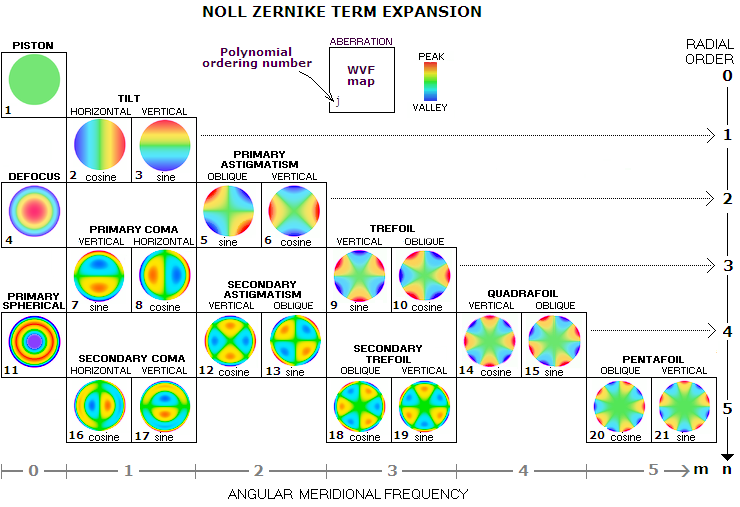

Do the transpose! 



In [ ]:
#2 : change fieldXY from [0,0] to the one from the task + image transpose 


In [43]:
intra_stamp = donutIntra.stamp_im.image.array.T
extra_stamp = donutExtra.stamp_im.image.array.T
wepZk = {}
for model in ['onAxis', 'paraxial']:
    wepZk[model] = fit_ts_wep(intra_stamp, extra_stamp, fieldXYIntra=fieldXYIntra, 
                              fieldXYExtra=fieldXYExtra, sizeInPix = 240.,
                             opticalModel=model)
    idx = np.array([3,4,0])
    print(f'{model}', wepZk[model][idx])

onAxis [40.71831918 68.52932968 69.14695218]
paraxial [40.62700301 68.57103954 69.036601  ]


In [48]:
fit_cwfs?

In [47]:

cwfsZk = {}
for model in ['onAxis', 'paraxial']:
    cwfsZk[model] = fit_cwfs(intra_stamp, extra_stamp, fieldXYIntra=fieldXYIntra, 
                              fieldXYExtra=fieldXYExtra, side = 120,
                             opticalModel=model)
    idx = np.array([3,4,0])
    print(f'{model}', cwfsZk[model][idx])

onAxis [40.05966187 61.57216876 84.27356796]
paraxial [35.07724114 66.81251049 83.16888947]


Task had for  -zk[3],zk[4],zk[0]:

[-40.7183191777229, 68.5293296830927, 69.14695218328815]

i.e. exactly the same! 

So now we know that:
    
    a) WEP transposes the images. That was needed for phoSim. Perhaps not for auxTel images. 
    b) WEP uses fieldXY that is calculated when the  donutStamps are cutout, given the donutCatalog. It is NOT [0,0] (different from boresight)
    
    

In summary , I compared running CWFS and running WEP, in a very similar way (where few settings are made to the instrument class, and passed on to the Algorithm class, I access the Algorithm results directly):
    
    cwfs obscuration = 0.423 (incorrect), fieldXY [0,0]
    
    cwfs,  zk[3 4 0]
      * paraxial [59.73379934 30.60085417 50.73205137]
       onAxis [59.09897731 30.75532185 50.87899948]
    
    wep direct  zk[3 4 0], obscuration = 0.3525 (set in policy yaml files )
       paraxial [66.5005612  35.41708688 71.7400073 ]
      * onAxis [66.4078707  41.71824437 72.44878706]
    
In `latiss_cwfs_align` the result was compared to incorrect "truth". I get the same as "truth" (being [-60,30,50]) if I use incorrect obscuration, and fieldXY=[0,0].


When we set  obscuration = 0.3525 (correct) in cwfs, we get 

    cwfs,  zk[3 4 0]
       paraxial [61.2194822  40.71669334 90.19797476]
       onAxis [65.46545243 40.89667399 90.28558608]


Now in `latiss_wep_align` we were using `EstimateZernikesLatissTask`. Running the task exactly as  in `latiss_wep_align` gave different results than running it in the direct way:

    wep task zk[3 4 0]
      onAxis [40.7183191, 68.5293296, 69.1469521]
   
But the difference between `wep direct` and `wep task` is that 

a) in `task` the fieldXY is calculated based on the `DonutStamp` cut out at the locations indicated by the `DonutCatalog`, 
b) in `task` the image is transposed when it's fed to WEP

When I run `wep direct` with the 

    fieldXYExtra  (0.02878824583333334, 0.016613715277777767)
    fieldXYIntra  (0.028867991666666672, 0.01650738749999999)

(as in `wep task`), I get 

    wep direct onAxis [68.52932968 40.71831918 69.14695218]
    
and if I use these `fieldXY` and do the `transpose` of the stamp, I get 


    wep direct onAxis [40.71831918 68.52932968 69.14695218]
    
i.e. the same as when running the `task`. 


When running `cwfs` with these `fieldXY` and `transpose` , I get (using obscuration 0.3525) 

    cwfs onAxis [40.05966187 61.57216876 84.27356796] 
    cwfs paraxial [35.07724114 66.81251049 83.16888947]
    
i.e. within the tested differences between the two codes. 

In [ ]:
Summary of recommendations:
    - switch as "truth" to results of fitting with obscuration corrected to `0.3525` 
    - use `wep`, but instead of `EstimateZernikesLatissTask` use `CutOutDonuts` and `CalcZernikes` 
    - consider whether there should be a transpose of input images (based on the `batoid` simulations, I don't think so)